In [1]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
netflix_titles = pd.read_csv('../data/final_data/complete_manually_cleaned_data.csv')

In [5]:
ratings = pd.read_csv('../data/external/title.ratings.tsv', sep='\t')

basics = pd.read_csv('../data/external/title.basics.tsv', sep='\t', usecols=['tconst', 'titleType', 'runtimeMinutes', 'genres'])

In [6]:
df = netflix_titles.merge(ratings, how='left', on='tconst').merge(basics, how='left', on='tconst')

In [7]:
# df.loc[(~df['is_tv_show']) & df['titleType'].isin(['tvMiniSeries', 'tvSeries']), 'season'] = accidental_tv_show_in_movie['combined_title'].str.extract(r' (\d+)', expand=False).fillna(1)
# df.loc[df['season'].notnull(), 'is_tv_show'] = True

In [8]:
#Lets also combine movie with tvMovie and short with Tvshort
df.loc[df['titleType'] == 'tvMovie', 'titleType'] = 'movie'
df.loc[df['titleType'] == 'tvShort', 'titleType'] = 'short'

#Waffles + Mochi's Holiday Feast is a holiday special of a tv show, let's label it as a tvSpecial
df.loc[df['combined_title'] == 'Waffles + Mochi\'s Holiday Feast', 'titleType'] = 'tvSpecial'


In [9]:
df[(~df['is_tv_show'])]['titleType'].value_counts()

movie        742
tvSpecial    130
short         45
Name: titleType, dtype: int64

In [10]:
#My Wonderful Life Manually added data

df.loc[df['combined_title']=='My Wonderful Life', 'averageRating'] = 5.9
df.loc[df['combined_title']=='My Wonderful Life', 'numVotes'] = 714
df.loc[df['combined_title']=='My Wonderful Life', 'titleType'] = 'movie'
df.loc[df['combined_title']=='My Wonderful Life', 'runtimeMinutes'] = 99
df.loc[df['combined_title']=='My Wonderful Life', 'genres'] = 'Comedy,Drama,Romance'

In [11]:
#df.to_csv('../data/interim/merged_data.csv', index=False)

In [12]:
#removes the storybot shorts and The New which have no data on imdb
df = df[df['averageRating'].notnull()].copy()

In [13]:
#Top 10 to int
df['is_top10'] = df['is_top10'].astype(int)

#Replace \N with NaN
df.replace('\\N', np.nan, inplace=True)

#Rename title to lower_title
df.rename(columns={'title': 'lower_title'}, inplace=True)

In [14]:
#Fix dtypes
df['runtimeMinutes'] = df['runtimeMinutes'].astype(float)
df['numVotes'] = df['numVotes'].astype(int)

## A little feature engineering with release date

In [15]:
# Turn release date into datetime
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y%m%d')

# Add month, week, quarter
df['release_date_quarter'] = df['release_date'].dt.quarter
df['release_date_month'] = df['release_date'].dt.month
df['release_date_week'] = df['release_date'].dt.isocalendar().week

In [17]:
#df.to_csv('../data/processed/feed_into_pipeline_data.csv', index=False)

## START HERE IF YOU HAVE THE ABOVE FILE ALREADY

In [ ]:
df = pd.read_csv('../data/processed/feed_into_pipeline_data.csv')

## Adding Summaries and People Rankings

In [18]:
summaries = pd.read_csv('../data/interim/GlobalOriginalsWithSummary.csv')[['combined_title', 'summary']]
people_rankings = pd.read_csv('../data/interim/showsWithPrinicpalRankings.csv')[['combined_title', 'director_rank', 'writer_rank', 'actor_rank']]

In [19]:
df = df.merge(summaries, on='combined_title')
df = df.merge(people_rankings, on='combined_title')

## Split the data into movies and tv, then train/test split

In [20]:
#Split movie and tv_show
movies, tv_shows = df[df['is_tv_show']==False], df[df['is_tv_show']==True]

## Movies

In [21]:
# drop columns that are not needed
movies = movies.drop(['tconst', 'release_date', 'combined_title', 'lower_title', 'season', 'is_tv_show'], axis = 1, errors = 'ignore')

In [22]:
# train test split with stratified sampling
from sklearn.model_selection import train_test_split

movie_X_train, movie_X_test, movie_y_train, movie_y_test = train_test_split(movies.drop('is_top10', axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])


### Bag of Words with genre

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

#Create a count vectorizer to count the number of words in the genres column
count_vectorizer = CountVectorizer(min_df=0.05, max_df=0.99, binary=True, token_pattern=r'(?u)[a-zA-Z][a-z -]+')
count_vectorizer.fit(movie_X_train['genres'])

CountVectorizer(binary=True, max_df=0.99, min_df=0.05,
                token_pattern='(?u)[a-zA-Z][a-z -]+')

In [34]:
#Transform the genres column
genres_train = count_vectorizer.transform(movie_X_train['genres'])
#Convert to a dataframe
genres_train = pd.DataFrame(genres_train.todense(), columns=count_vectorizer.get_feature_names_out())

#Transform the genres column
genres_test = count_vectorizer.transform(movie_X_test['genres'])
#Convert to a dataframe
genres_test = pd.DataFrame(genres_test.todense(), columns=count_vectorizer.get_feature_names_out())

In [36]:
movie_X_train = pd.concat([movie_X_train.reset_index(drop=True), genres_train], axis=1).drop(columns=['genres'])
movie_X_test = pd.concat([movie_X_test.reset_index(drop=True), genres_test], axis=1).drop(columns=['genres'])

In [38]:
import seaborn as sns

Text(0.05, 0.95, 'p-value: 0.74')

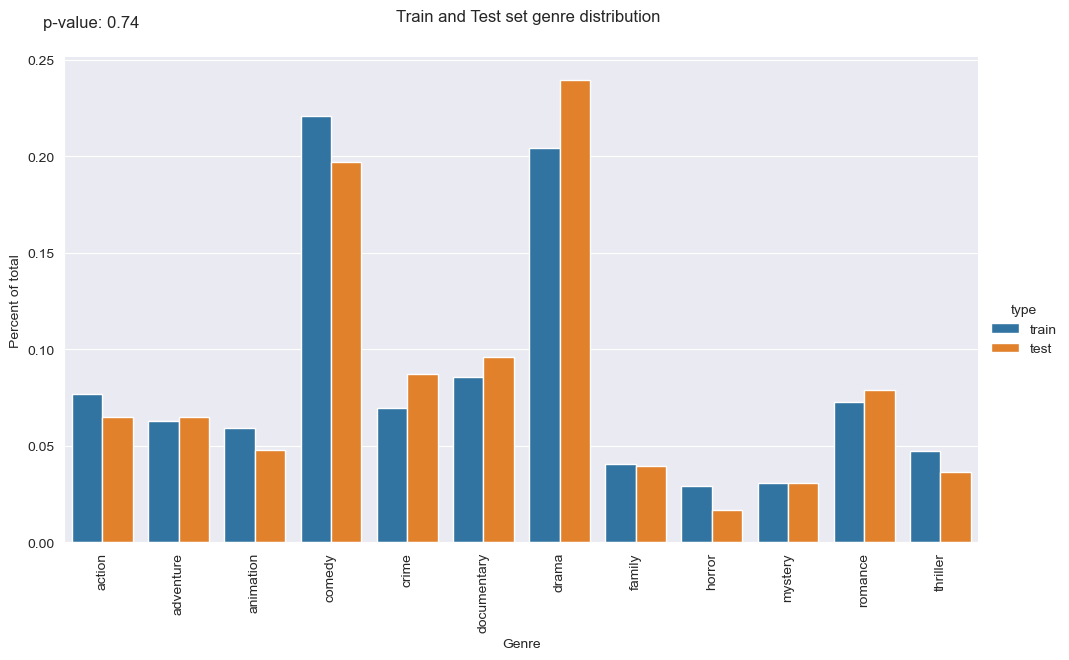

In [ ]:
#plot the train and test set genre distributions with offset to see if they are similar

ax = sns.catplot(y='percent_counts', x='index', hue='type', data=genres_temp, kind='bar', height=6, aspect=10/6)

ax.set_xticklabels(rotation=90)

#annotate a chi square test to see if the distributions are statistically different

from scipy.stats import chi2_contingency

chi2_contingency([genres_train.sum(), genres_test.sum()])
ax.set_axis_labels('Genre', 'Percent of total')
ax.fig.suptitle('Train and Test set genre distribution')
ax.fig.subplots_adjust(top=0.9)
ax.fig.text(0.05, 0.95, f'p-value: {chi2_contingency([genres_train.sum(), genres_test.sum()])[1]:.2f}', fontsize=12)

In [ ]:
# Now add the genres to the train and test set

X_train = pd.concat([X_train.reset_index(drop=True), genres_train], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), genres_test], axis=1)

### Bag of Words using Summary

In [61]:
#Bag of words for summary
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', min_df=0.02)
summary_transformed = vectorizer.fit_transform(movie_X_train['summary'])

In [66]:
# Create a dataframe with the words as columns
movie_bow_train = pd.DataFrame(summary_transformed.toarray(), columns=vectorizer.get_feature_names_out())
movie_bow_test = pd.DataFrame(vectorizer.transform(movie_X_test['summary']).toarray(), columns=vectorizer.get_feature_names_out())

### Alternatively TF-IDF

In [49]:
# TF-IDF for summary
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=0.01)
summary_transformed = vectorizer.fit_transform(summaries['summary'])

# Create a dataframe with the words as columns
tfidf_df = pd.DataFrame(summary_transformed.toarray(), columns=vectorizer.get_feature_names_out())

In [50]:
tfidf_df

,000,adventure,adventures,america,american,animated,attempt,away,based,battle,...,win,woman,women,work,working,world,year,years,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382812,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000
2222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.555733,0.0,0.00000,0.0,0.0,0.000000,0.000000
2223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.480926,0.317506
2224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.517572,0.000000,0.0,0.36048,0.0,0.0,0.000000,0.000000


### Alternatively Hugging Face

In [87]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

#Create embeddings for the summaries
summary_embeddings = model.encode(summaries['summary'], convert_to_numpy=True)


c:\ProgramData\Miniconda3\envs\netflix_proj\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
#Create a dataframe with the embeddings as columns and name them    

summary_embeddings_df = pd.DataFrame(summary_embeddings, columns=[f'summary_embedding_{i}' for i in range(summary_embeddings.shape[1])])

In [23]:
summary_embeddings_df

,summary_embedding_0,summary_embedding_1,summary_embedding_2,summary_embedding_3,summary_embedding_4,summary_embedding_5,summary_embedding_6,summary_embedding_7,summary_embedding_8,summary_embedding_9,...,summary_embedding_374,summary_embedding_375,summary_embedding_376,summary_embedding_377,summary_embedding_378,summary_embedding_379,summary_embedding_380,summary_embedding_381,summary_embedding_382,summary_embedding_383
0,-0.026633,0.018920,-0.055134,0.045714,-0.063023,-0.032902,-0.024073,-0.049662,0.021096,-0.002936,...,0.073990,-0.024292,-0.000128,0.056980,-0.071850,0.032407,0.101245,0.041416,0.107043,-0.010314
1,0.008881,-0.022368,0.007538,0.018812,-0.003038,0.020658,-0.104257,-0.010471,-0.032509,-0.071558,...,-0.009092,0.048180,0.053298,-0.018979,-0.034616,-0.023176,0.066810,-0.137848,0.092657,0.052799
2,-0.023224,-0.003328,-0.020494,0.026740,-0.009808,-0.004658,-0.028434,-0.025144,0.017680,-0.029676,...,0.073531,-0.027467,0.035513,-0.008700,0.048015,0.016851,0.014063,-0.039804,-0.037779,-0.008573
3,-0.019948,0.036421,-0.032200,0.017349,-0.001934,-0.001572,0.068681,-0.014159,-0.022527,0.040237,...,0.090168,0.066829,0.020300,0.105946,-0.012541,0.031277,0.135142,0.099034,-0.108421,-0.074679
4,0.007733,0.069801,-0.040708,0.076647,-0.006824,0.048367,0.059733,-0.014537,-0.030768,-0.005307,...,-0.013327,-0.027364,-0.082106,0.015057,-0.101740,-0.069111,0.029374,-0.031163,0.035734,0.029763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,0.065544,-0.016539,0.012974,-0.012867,0.042465,-0.021782,0.080996,-0.081871,0.007024,-0.049119,...,0.045124,-0.071766,-0.008403,0.036693,0.010890,0.043983,0.011136,-0.017340,0.033225,-0.048873
2222,0.016400,-0.043311,0.054263,0.004811,-0.032548,0.047001,0.047832,-0.020683,-0.009917,-0.056862,...,-0.027186,0.055188,-0.066201,0.048929,-0.124170,-0.050052,0.110961,-0.032043,-0.007126,0.028938
2223,0.065066,-0.001605,0.029295,-0.036900,-0.028460,0.093836,0.075292,-0.038419,-0.066347,-0.012721,...,0.028930,-0.037840,-0.103201,0.142967,-0.044767,0.014078,0.010336,0.031978,0.020591,-0.086957
2224,-0.018001,-0.053426,-0.103662,0.075346,-0.018186,0.045000,0.067063,-0.010451,0.007042,0.041649,...,-0.015691,-0.069962,0.021161,0.045569,-0.052063,0.110053,-0.054747,-0.060268,0.044384,-0.028002


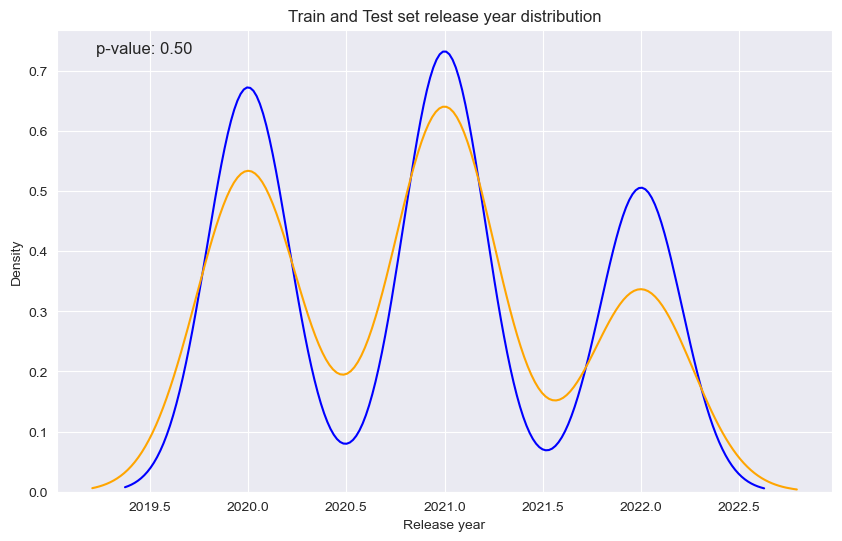

In [80]:
#Make sure the train and test set release year distribution is not statistically different

from scipy.stats import ttest_ind

ttest_ind(X_train['release_year'], X_test['release_year'])

#Now plot it

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['release_year'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['release_year'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set release year distribution')
ax.set_xlabel('Release year')
ax.set_ylabel('Density')
ax.annotate(f'p-value: {ttest_ind(X_train["release_year"], X_test["release_year"])[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

In [ ]:
#Calculate chi2 for release_date_month

from scipy.stats import chi2_contingency

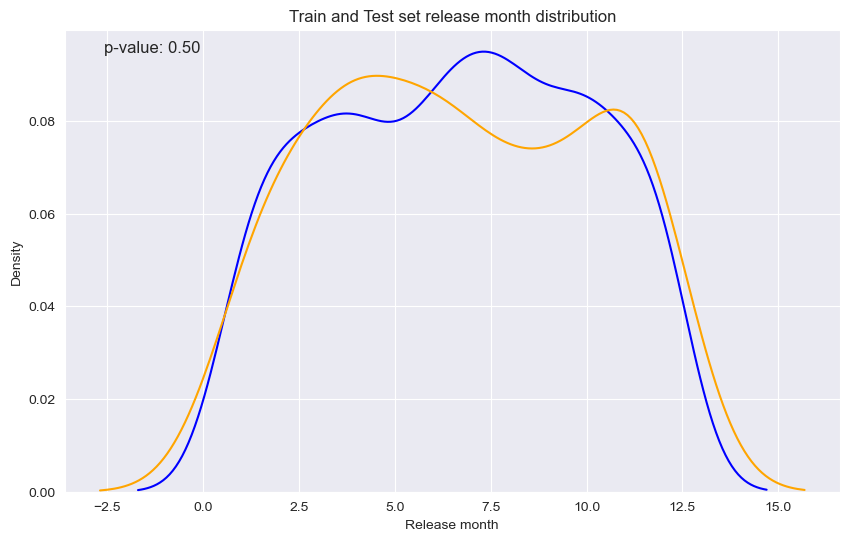

In [116]:
#Plot and compare the train and test set release month distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['release_date_month'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['release_date_month'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set release month distribution')
ax.set_xlabel('Release month')
ax.set_ylabel('Density')

#Annotate chi2 test result
chi2, p, dof, expected = chi2_contingency(pd.DataFrame({"train": X_train['release_date_month'].value_counts().sort_index(), "test": X_test['release_date_month'].value_counts().sort_index()}))
ax.annotate(f'p-value: {p:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

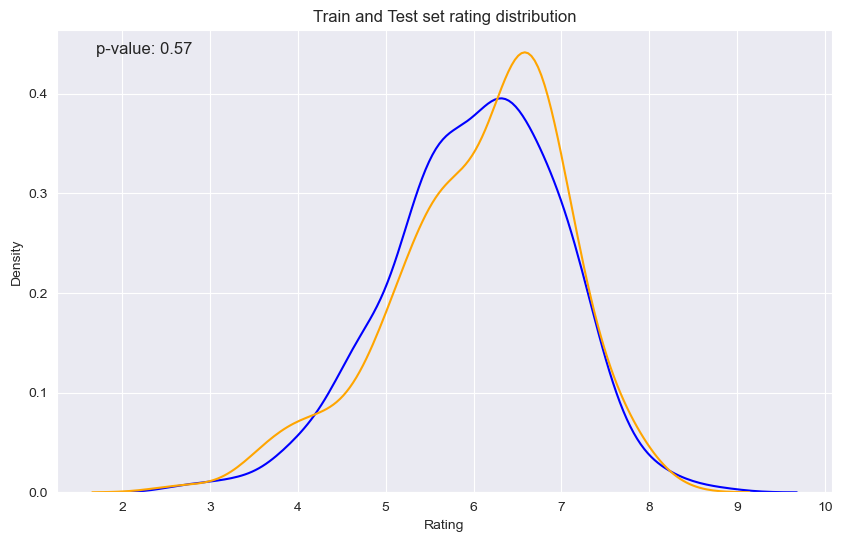

In [118]:
#Plot and compare the train and test set rating distribution



fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['averageRating'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['averageRating'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set rating distribution')
ax.set_xlabel('Rating')
ax.set_ylabel('Density')

# Annotate p-value
ax.annotate(f'p-value: {ttest_ind(X_train["averageRating"], X_test["averageRating"])[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

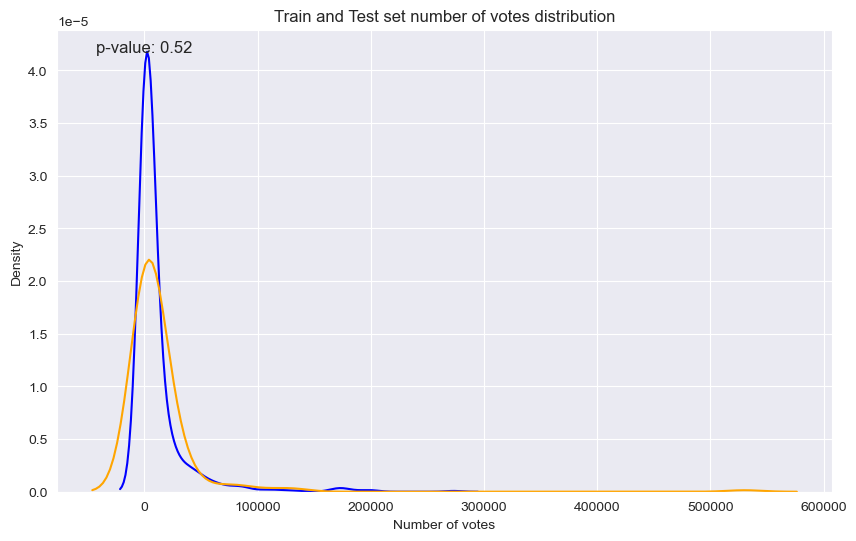

In [82]:
# Plot and compare the train and test set number of votes distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['numVotes'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['numVotes'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set number of votes distribution')
ax.set_xlabel('Number of votes')
ax.set_ylabel('Density')
ax.annotate(f'p-value: {ttest_ind(X_train["numVotes"], X_test["numVotes"])[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

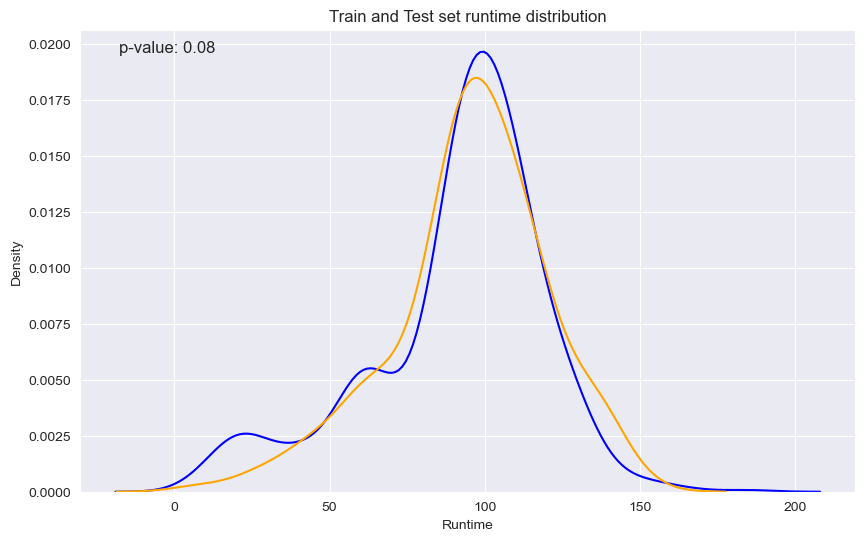

In [119]:
#Plot and compare the train and test set runtime distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['runtimeMinutes'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['runtimeMinutes'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set runtime distribution')
ax.set_xlabel('Runtime')
ax.set_ylabel('Density')
ax.annotate(f'p-value: {ttest_ind(X_train["runtimeMinutes"].dropna(), X_test["runtimeMinutes"].dropna())[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

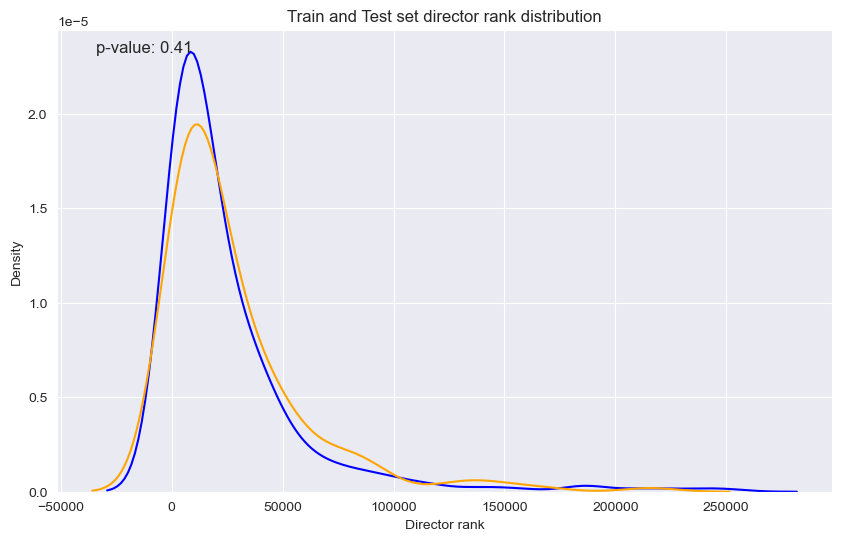

In [100]:
# Plot and compare the train and test set director rank distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['director_rank'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['director_rank'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set director rank distribution')
ax.set_xlabel('Director rank')
ax.set_ylabel('Density')
ax.annotate(f'p-value: {ttest_ind(X_train["director_rank"].dropna(), X_test["director_rank"].dropna())[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

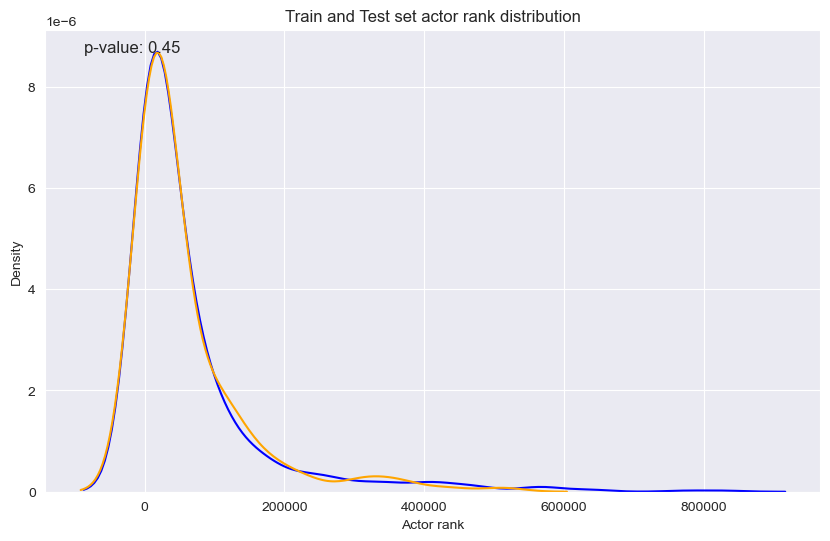

In [120]:
# Plot and compare the train and test set actor distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['actor_rank'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['actor_rank'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set actor rank distribution')
ax.set_xlabel('Actor rank')
ax.set_ylabel('Density')

ax.annotate(f'p-value: {ttest_ind(X_train["actor_rank"].dropna(), X_test["actor_rank"].dropna())[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()


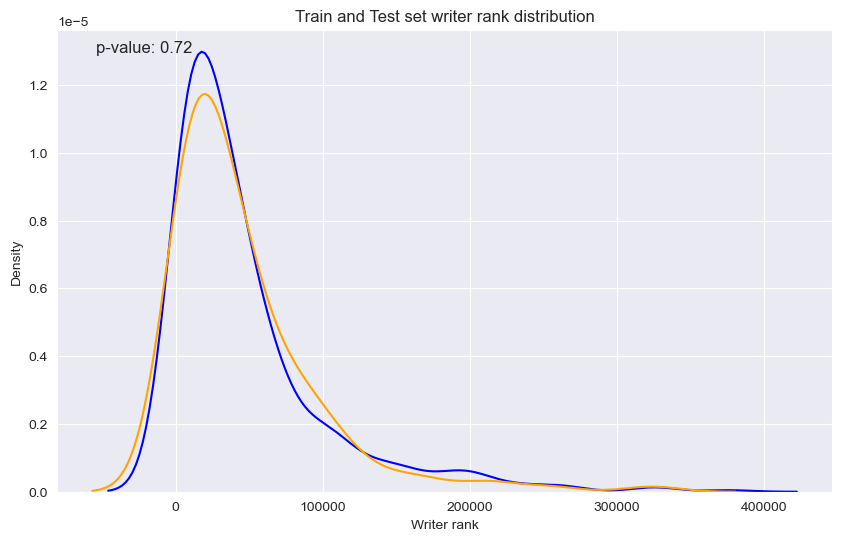

In [121]:
# Plot and compare the train and test set writer distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['writer_rank'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['writer_rank'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set writer rank distribution')
ax.set_xlabel('Writer rank')
ax.set_ylabel('Density')
ax.annotate(f'p-value: {ttest_ind(X_train["writer_rank"].dropna(), X_test["writer_rank"].dropna())[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

Bag of Words for Genres

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

#Create a count vectorizer to count the number of words in the genres column
count_vectorizer = CountVectorizer(min_df=0.05, max_df=0.99, binary=True, token_pattern=r'(?u)[a-zA-Z][a-z -]+')
count_vectorizer.fit(movie_X_train['genres'])

CountVectorizer(binary=True, max_df=0.99, min_df=0.05,
                token_pattern='(?u)[a-zA-Z][a-z -]+')

In [29]:
#Transform the genres column
genres_train = count_vectorizer.transform(movie_X_train['genres'])
#Convert to a dataframe
genres_train = pd.DataFrame(genres_train.todense(), columns=count_vectorizer.get_feature_names_out())

#Transform the genres column
genres_test = count_vectorizer.transform(movie_X_test['genres'])
#Convert to a dataframe
genres_test = pd.DataFrame(genres_test.todense(), columns=count_vectorizer.get_feature_names_out())

In [203]:
train_genres_temp = pd.DataFrame({"percent_counts": genres_train.sum()/genres_train.sum().sum(), "type": "train"}).reset_index()
test_genres_temp = pd.DataFrame({"percent_counts": genres_test.sum()/genres_test.sum().sum(), "type": "test"}).reset_index()

genres_temp = pd.concat([train_genres_temp, test_genres_temp], axis=0)

Text(0.05, 0.95, 'p-value: 0.74')

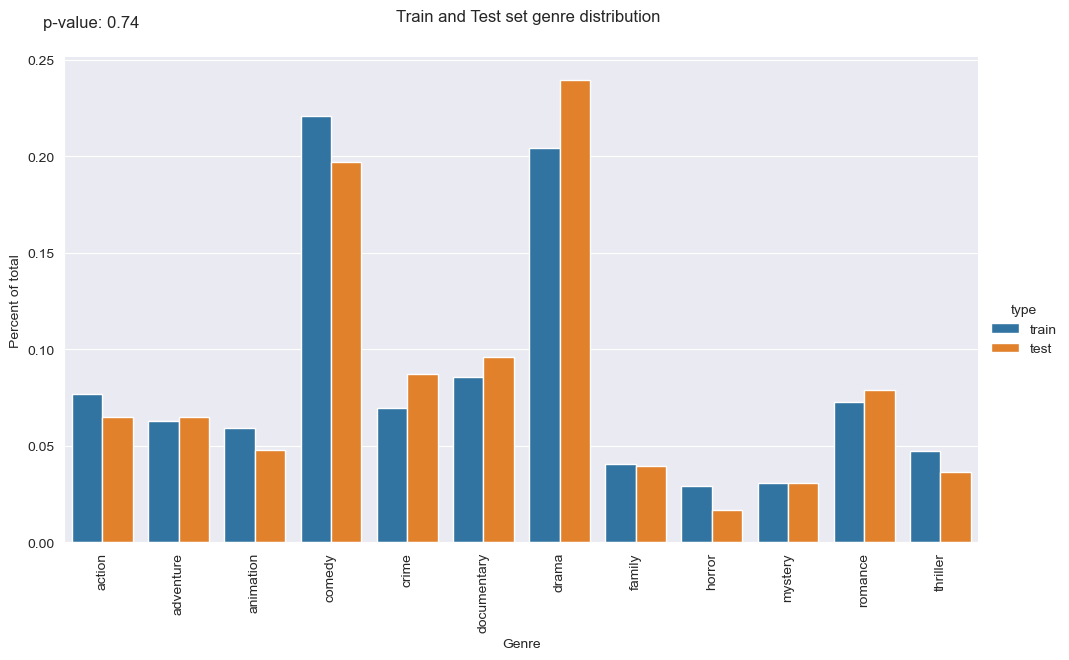

In [181]:
#plot the train and test set genre distributions with offset to see if they are similar

ax = sns.catplot(y='percent_counts', x='index', hue='type', data=genres_temp, kind='bar', height=6, aspect=10/6)

ax.set_xticklabels(rotation=90)

#annotate a chi square test to see if the distributions are statistically different

from scipy.stats import chi2_contingency

chi2_contingency([genres_train.sum(), genres_test.sum()])
ax.set_axis_labels('Genre', 'Percent of total')
ax.fig.suptitle('Train and Test set genre distribution')
ax.fig.subplots_adjust(top=0.9)
ax.fig.text(0.05, 0.95, f'p-value: {chi2_contingency([genres_train.sum(), genres_test.sum()])[1]:.2f}', fontsize=12)

In [207]:
# Now add the genres to the train and test set

X_train = pd.concat([X_train.reset_index(drop=True), genres_train], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), genres_test], axis=1)

Everything looks good! Next step:

## Fill Blanks

In [209]:
from sklearn.impute import SimpleImputer

#Create a simple imputer to fill in the missing values with the mean
imputer = SimpleImputer(strategy='mean')

#Fit the imputer to the train set
imputer.fit(X_train[['runtimeMinutes']])
#Transform the train set
X_train['runtimeMinutes'] = imputer.transform(X_train[['runtimeMinutes']])
#Transform the test set
X_test['runtimeMinutes'] = imputer.transform(X_test[['runtimeMinutes']])
#Check the results
X_train['runtimeMinutes'].isna().sum()

0

In [210]:
X_train['null_writer'] = X_train['writer_rank'].isna().astype(int)
X_test['null_writer'] = X_test['writer_rank'].isna().astype(int)

X_train['null_director'] = X_train['director_rank'].isna().astype(int)
X_test['null_director'] = X_test['director_rank'].isna().astype(int)

X_train['null_actor'] = X_train['actor_rank'].isna().astype(int)
X_test['null_actor'] = X_test['actor_rank'].isna().astype(int)

In [211]:
max_writer = SimpleImputer(strategy='mean')
max_imputer.fit(X_train[['writer_rank']])
X_train['writer_rank'] = max_imputer.transform(X_train[['writer_rank']])
X_test['writer_rank'] = max_imputer.transform(X_test[['writer_rank']])

max_director = SimpleImputer(strategy='mean')
max_director.fit(X_train[['director_rank']])
X_train['director_rank'] = max_director.transform(X_train[['director_rank']])
X_test['director_rank'] = max_director.transform(X_test[['director_rank']])

max_actor = SimpleImputer(strategy='mean')
max_actor.fit(X_train[['actor_rank']])
X_train['actor_rank'] = max_actor.transform(X_train[['actor_rank']])
X_test['actor_rank'] = max_actor.transform(X_test[['actor_rank']])

<AxesSubplot:xlabel='writer_rank', ylabel='Density'>

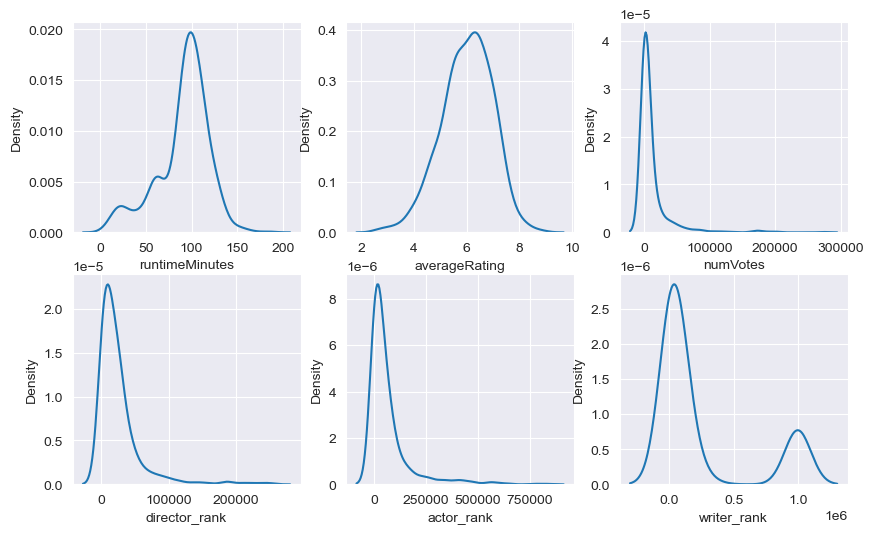

In [212]:
#Check distribution of the train set features

fig, ax = plt.subplots(2, 3, figsize=(10, 6))
sns.kdeplot(X_train['runtimeMinutes'], ax=ax[0, 0])
sns.kdeplot(X_train['averageRating'], ax=ax[0, 1])
sns.kdeplot(X_train['numVotes'], ax=ax[0, 2])

sns.kdeplot(X_train['director_rank'], ax=ax[1, 0])
sns.kdeplot(X_train['actor_rank'], ax=ax[1, 1])
sns.kdeplot(X_train['writer_rank'], ax=ax[1, 2])

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [42]:
rankings_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('logger', FunctionTransformer(np.log1p))
])

linear_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
        ("onehot_release_year",OneHotEncoder(drop='first', handle_unknown='ignore'), ['release_year']),
        ("genres_count", CountVectorizer(min_df=0.05), 'genres'),
        ("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),
        ("rankings_pipeline", rankings_pipeline, ['director_rank', 'actor_rank', 'writer_rank']),
    ],
    remainder='passthrough')

In [49]:
#make sklearn pipeline with transform, normalization, and model
pipe = Pipeline(
    steps=[
        ('linear_transformer', linear_transformer),
        ('normalizer', sklearn.preprocessing.Normalizer()),
        #('feature_selection', SelectFromModel(sklearn.linear_model.LogisticRegression())),
        ('logistic_regress', sklearn.linear_model.LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000))
    ]
)

In [50]:
from sklearn.model_selection import GridSearchCV

In [63]:
logistic_gs = GridSearchCV(
    pipe,
    param_grid={
        'logistic_regress__penalty': ['elasticnet'],
        'logistic_regress__C': [100, 200, 300, 500, 1000],
        'logistic_regress__l1_ratio': [0, 0.1, 0.5, 0.9, 1],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [64]:
logistic_gs.fit(movie_X_train.drop(columns=["summary"]), movie_y_train)

c:\ProgramData\Miniconda3\envs\netflix_proj\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('linear_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_titleType',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('onehot_release_year',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['release_year']),
                                                                        ('genres_count',
                                                                         CountVectorizer(min_df=0.05),
                                                                         'ge...
                                                                          'writer_rank'])])),
                                       ('normalizer', Normalizer()),
                                       ('logistic_regress',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logistic_regress__C': [100, 200, 300, 500, 1000],
                         'logistic_regress__l1_ratio': [0, 0.1, 0.5, 0.9, 1],
                         'logistic_regress__penalty': ['elasticnet']},
             refit='AUC', scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'})

In [65]:
logistic_gs.best_params_

{'logistic_regress__C': 1000,
 'logistic_regress__l1_ratio': 1,
 'logistic_regress__penalty': 'elasticnet'}

In [66]:
logistic_gs.best_score_ #.7274 C=1000, l1_ratio=1

0.7274018066017431

### Let's try with XGBoost

In [67]:
from xgboost import XGBClassifier

c:\ProgramData\Miniconda3\envs\netflix_proj\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [68]:
#import tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

In [69]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embedder = FunctionTransformer(lambda item:model.encode(item, convert_to_tensor=True, show_progress_bar=False).detach().cpu().numpy())

NameError: name 'SentenceTransformer' is not defined

In [70]:
rankings_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    ('logger', FunctionTransformer(np.log1p))
])

xgb_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),
        ("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),
        #("bagofwords", CountVectorizer(stop_words='english', min_df=0.02), 'summary'),
        ("tfidf", TfidfVectorizer(stop_words='english', min_df=0.02), 'summary'),
        ("genres_count", CountVectorizer(min_df=0.05), 'genres'),
        #("sentence_transformer", embedder, 'summary'),
        #("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),
        ("rankings_pipeline", rankings_pipeline, ['director_rank', 'actor_rank', 'writer_rank']),
    ],
    remainder='passthrough')

In [74]:
# Recreate pipeline using XGBoost

xgb_pipe = Pipeline(
    steps=[
        ('xgb_transformer', xgb_transformer),
        #('normalizer', sklearn.preprocessing.Normalizer()),
        ('xgb', XGBClassifier())
    ]
)

xgb_gs = GridSearchCV(
    xgb_pipe,
    param_grid={
        'xgb__max_depth': [3, 5, 7],
        'xgb__learning_rate': [0.01, 0.1, 0.5],
        'xgb__n_estimators': [100, 200, 300]
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [75]:
xgb_gs.fit(movie_X_train.drop(columns=['summary']), movie_y_train)

c:\ProgramData\Miniconda3\envs\netflix_proj\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_titleType',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('onehot_release_year',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['release_year']),
                                                                        ('genres_count',
                                                                         CountVectorizer(min_df=0.05),
                                                                         'genres'),
                                                                        ('rankings_pipeline',
                                                                         P...
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.1, 0.5],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [100, 200, 300]},
             refit='AUC', scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'})

In [76]:
xgb_gs.best_score_
#0.825311 no summary
#0.827196 with bow summary
#0.825758 with tfidf summary
#

0.8253115136478474

In [77]:
#get auc of test set
from sklearn.metrics import roc_auc_score
roc_auc_score(movie_y_test, xgb_gs.predict_proba(movie_X_test)[:,1])



0.8358191287878788

In [384]:
#Get validation results
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_regress__C,param_logistic_regress__solver,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,...,std_test_AUC,rank_test_AUC,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy
0,0.026595,0.003490,0.039486,0.004962,0.01,lbfgs,"{'logistic_regress__C': 0.01, 'logistic_regres...",0.651391,0.696846,0.705523,...,0.021312,9,0.598639,0.598639,0.551020,0.623288,0.568493,0.588016,0.025376,9
1,0.038829,0.010881,0.038138,0.006065,0.01,saga,"{'logistic_regress__C': 0.01, 'logistic_regres...",0.651391,0.696846,0.705523,...,0.021312,9,0.598639,0.598639,0.551020,0.623288,0.568493,0.588016,0.025376,9
2,0.027250,0.003562,0.039256,0.008312,0.1,lbfgs,"{'logistic_regress__C': 0.1, 'logistic_regress...",0.657885,0.701484,0.705523,...,0.019796,7,0.625850,0.639456,0.666667,0.623288,0.630137,0.637079,0.015783,7
3,0.043150,0.008035,0.034918,0.006552,0.1,saga,"{'logistic_regress__C': 0.1, 'logistic_regress...",0.657885,0.701484,0.705523,...,0.019824,8,0.625850,0.639456,0.666667,0.623288,0.630137,0.637079,0.015783,7
4,0.032708,0.005171,0.037116,0.006953,1,lbfgs,"{'logistic_regress__C': 1, 'logistic_regress__...",0.655473,0.700371,0.706449,...,0.019153,1,0.632653,0.632653,0.653061,0.643836,0.630137,0.638468,0.008704,5
5,0.036346,0.007905,0.036493,0.008743,1,saga,"{'logistic_regress__C': 1, 'logistic_regress__...",0.655473,0.700371,0.706449,...,0.019153,1,0.632653,0.632653,0.653061,0.643836,0.630137,0.638468,0.008704,5
6,0.029699,0.004024,0.033085,0.012569,10,lbfgs,"{'logistic_regress__C': 10, 'logistic_regress_...",0.655288,0.700371,0.708673,...,0.020665,3,0.646259,0.639456,0.659864,0.650685,0.630137,0.645280,0.010061,1
7,0.035425,0.007383,0.025582,0.001780,10,saga,"{'logistic_regress__C': 10, 'logistic_regress_...",0.655288,0.700371,0.708673,...,0.020665,3,0.646259,0.639456,0.659864,0.650685,0.630137,0.645280,0.010061,1
8,0.035379,0.008880,0.024578,0.003527,100,lbfgs,"{'logistic_regress__C': 100, 'logistic_regress...",0.655288,0.700742,0.708117,...,0.021048,6,0.632653,0.639456,0.659864,0.643836,0.630137,0.641189,0.010524,3
9,0.092761,0.016166,0.016506,0.002355,100,saga,"{'logistic_regress__C': 100, 'logistic_regress...",0.655288,0.700742,0.708117,...,0.021016,5,0.632653,0.639456,0.659864,0.643836,0.630137,0.641189,0.010524,3
